# architecture-17 ( Basic Classification )

## What's new:

1- Add


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras import Input
import talib

# Constants
SEQUENCE_LENGTH = 60
FORECAST_HORIZON = 10

In [3]:
# Load dataset
df = pd.read_csv('datasets-17/XAGUSD-H1-rates.csv', sep='\t').dropna()

In [4]:
# Scaling Features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>']])

In [5]:
# Add RSI for post-processing
df['RSI'] = talib.RSI(df['<CLOSE>'], timeperiod=14)

# Label trend reversals (example: a simplistic method)
def label_trend_reversals(prices, window=5):
    labels = []
    for i in range(len(prices) - window):
        past = prices[i:i+window//2]
        future = prices[i+window//2:i+window]
        if np.mean(future) > np.mean(past):
            labels.append(1)  # potential buy
        elif np.mean(future) < np.mean(past):
            labels.append(2)  # potential sell
        else:
            labels.append(0)
    labels += [0] * window  # pad
    return labels

df['Label'] = label_trend_reversals(df['<CLOSE>'].values)


In [6]:
# Prepare Sequences
X, y = [], []
for i in range(SEQUENCE_LENGTH, len(scaled_data) - FORECAST_HORIZON):
    X.append(scaled_data[i-SEQUENCE_LENGTH:i])
    y.append(df['Label'].iloc[i:i+FORECAST_HORIZON].values)

X, y = np.array(X), np.array(y)


In [7]:
# Split Dataset
X_train = X[:-1]
y_train = y[:-1]

# Last 60 candles for prediction
X_input = X[-1:]
y_true_future = y[-1]  # for evaluation if desired


In [8]:
from tensorflow.keras.utils import to_categorical

# One-hot encode each timestep's class (3 classes → depth = 3)
y_onehot = np.array([to_categorical(row, num_classes=3) for row in y_train])
# Now shape = (num_samples, 10, 3)


In [11]:
# Build LSTM Classification Model
model = Sequential([
    Input(shape=(SEQUENCE_LENGTH, X.shape[2])),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(FORECAST_HORIZON * 3, activation='softmax'),
    tf.keras.layers.Reshape((FORECAST_HORIZON, 3))
])


In [12]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [13]:
# Train the Model
# Fit model
model.fit(X_train, y_onehot, epochs=10, batch_size=64, validation_split=0.1)


Epoch 1/10


I0000 00:00:1753373396.439664    4998 cuda_dnn.cc:529] Loaded cuDNN version 91001


774/774 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.4968 - loss: 0.7665 - val_accuracy: 0.4983 - val_loss: 0.6963
Epoch 2/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4999 - loss: 0.7014 - val_accuracy: 0.4968 - val_loss: 0.6968
Epoch 3/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4995 - loss: 0.7002 - val_accuracy: 0.4985 - val_loss: 0.6960
Epoch 4/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.4963 - loss: 0.6999 - val_accuracy: 0.5002 - val_loss: 0.6960
Epoch 5/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5018 - loss: 0.6993 - val_accuracy: 0.4977 - val_loss: 0.6961
Epoch 6/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5008 - loss: 0.6991 - val_accuracy: 0.5053 - val_loss: 0.6959
Epoch 7/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4989 - loss: 0.6999 - val_accuracy: 0.4988 - val_loss: 0.6967
Epoch 8/10
774/774 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5000 - loss: 0.7002 - val_accuracy: 0.5044 - val_

In [14]:
# Predict Next 10 Hours
pred_probs = model.predict(X_input)
pred_classes = np.argmax(pred_probs.reshape(FORECAST_HORIZON, 3), axis=1)

# Apply RSI filter
last_60_index = len(df) - FORECAST_HORIZON - 1
rsi_segment = df['RSI'].iloc[last_60_index+1:last_60_index+1+FORECAST_HORIZON].values
final_preds = []

for i, (pred, rsi) in enumerate(zip(pred_classes, rsi_segment)):
    if pred == 1 and rsi < 30:
        final_preds.append(1)  # buy
    elif pred == 2 and rsi > 70:
        final_preds.append(2)  # sell
    else:
        final_preds.append(0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


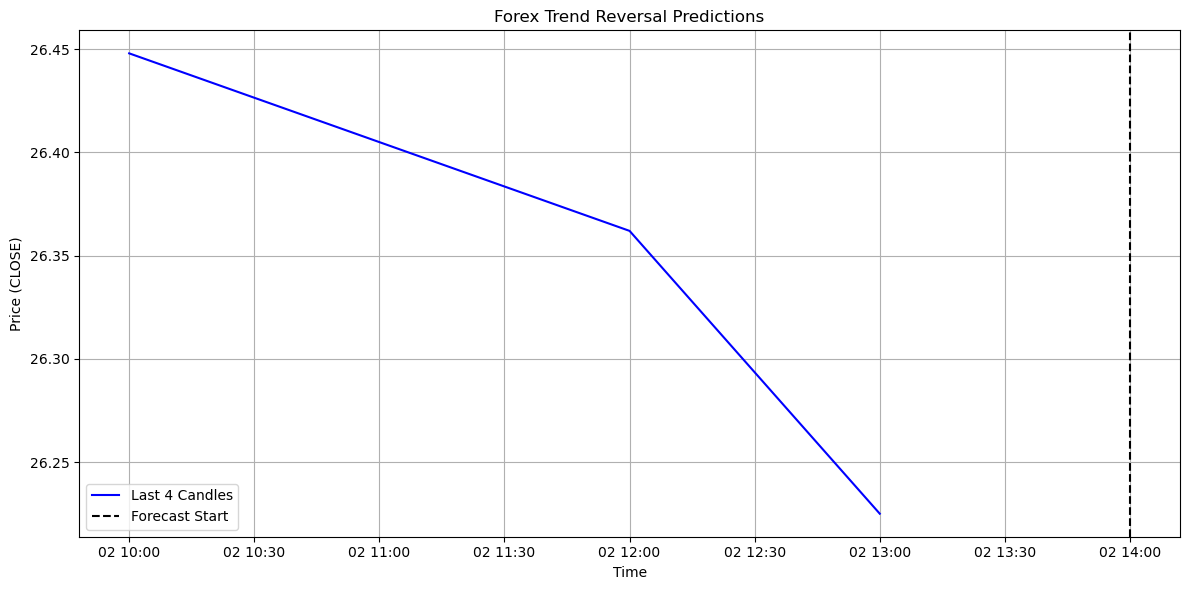

In [21]:
# Visualize Forecast
import matplotlib.dates as mdates

# Extract last 4 real candles
recent_candles = df.iloc[-FORECAST_HORIZON-4:-FORECAST_HORIZON]

# Fake future time axis
future_times = pd.to_datetime(df['<DATE>'] + ' ' + df['<TIME>'])
future_start = future_times.iloc[-FORECAST_HORIZON-1]
future_time_axis = [future_start + pd.Timedelta(hours=i+1) for i in range(FORECAST_HORIZON)]

# Plot
plt.figure(figsize=(12, 6))

# Plot the last 4 candles
plt.plot(future_times.iloc[-FORECAST_HORIZON-4:-FORECAST_HORIZON],
         recent_candles['<CLOSE>'], label='Last 4 Candles', color='blue')

# Vertical dotted line between real and forecast
plt.axvline(future_time_axis[0], linestyle='--', color='black', label='Forecast Start')

# Add vertical lines for predictions
for i, pred in enumerate(final_preds):
    if pred == 1:
        label = 'Buy'
        color = 'green'
    elif pred == 2:
        label = 'Sell'
        color = 'red'
    else:
        continue
    plt.axvline(future_time_axis[i], linestyle='--', color=color)
    plt.text(future_time_axis[i], plt.ylim()[1]*0.98, str(pred), color=color, fontsize=10, ha='center')

plt.xlabel('Time')
plt.ylabel('Price (CLOSE)')
plt.title('Forex Trend Reversal Predictions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
